# Data preprocessing

In [4]:
import sys
sys.path.append('../')

import numpy as np
import pathlib
import glob
import pretty_midi
import pandas as pd
from tqdm.auto import tqdm

from src.utils.midi import midi_to_notes, tokenize_notes, tokens_to_notes, notes_to_midi
from src.utils.data import NotesDataset

from typing import Optional
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

SAMPLING_RATE = 16000

In [5]:
data_dir = pathlib.Path('data/maestro-v3.0.0')
filenames = glob.glob(str(data_dir/'**/*.mid*'))

print(f'Number of MIDI files: {len(filenames)}')

Number of MIDI files: 1276


### Tokenize MIDI files

Select first file as an example

In [6]:
sample_file = filenames[0]
pm = pretty_midi.PrettyMIDI(sample_file)

Inspect intruments

In [7]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


Display raw file

In [8]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=SAMPLING_RATE)
    waveform_short = waveform[:seconds*SAMPLING_RATE]
    return display.Audio(waveform_short, rate=SAMPLING_RATE)

In [9]:
display_audio(pm)

Extract notes from MIDI file

In [10]:
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(
        f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}'
    )

0: pitch=71, note_name=B4, duration=0.4245
1: pitch=72, note_name=C5, duration=0.0599
2: pitch=74, note_name=D5, duration=0.0482
3: pitch=67, note_name=G4, duration=0.0273
4: pitch=55, note_name=G3, duration=0.0404
5: pitch=59, note_name=B3, duration=0.0339
6: pitch=67, note_name=G4, duration=0.0352
7: pitch=55, note_name=G3, duration=0.0299
8: pitch=69, note_name=A4, duration=0.0365
9: pitch=71, note_name=B4, duration=0.0625


In [18]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end
0,71,0.959635,1.384115
1,72,1.381510,1.441406
2,74,1.408854,1.457031
3,67,1.466146,1.493490
4,55,1.470052,1.510417


Plot piano roll

In [20]:
def plot_piano_roll(notes: pd.DataFrame, time: Optional[float] = None):
    if time is not None:
        title = f'First {time} seconds'
    else:
        time = notes['end'].max()
        title = 'All notes'
    
    notes_cropped = notes[notes['end'] <= time]

    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes_cropped['pitch'], notes_cropped['pitch']], axis=0)
    plot_start_stop = np.stack([notes_cropped['start'], notes_cropped['end']], axis=0)

    plt.plot(
        plot_start_stop, plot_pitch, color='b', marker='.'
    )
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    plt.title(title)

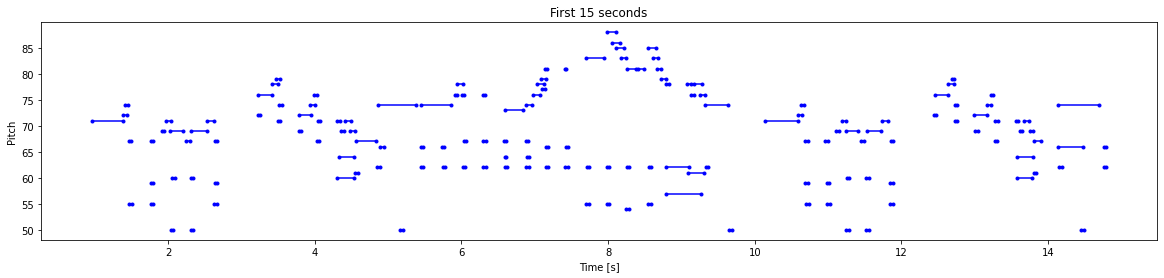

In [21]:
plot_piano_roll(raw_notes, time=15)

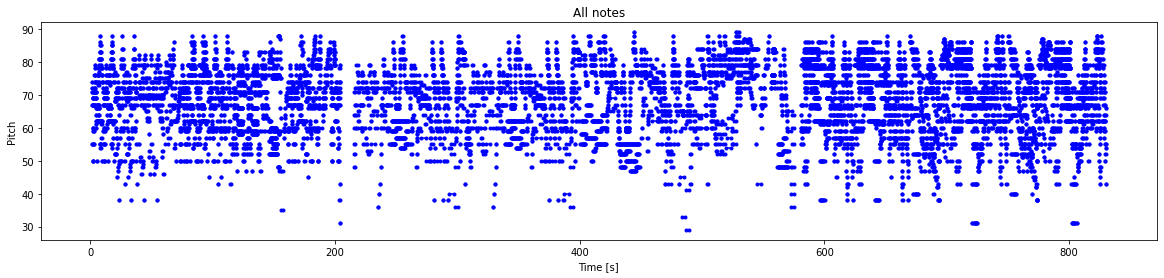

In [22]:
plot_piano_roll(raw_notes)

Plot notes pitch and duration distributions

In [23]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(notes, x='pitch', bins=20)

    plt.subplot(1, 2, 2)
    max_duration = np.percentile(notes['end'] - notes['start'], 100 - drop_percentile)
    sns.histplot(notes['end'] - notes['start'], bins=np.linspace(0, max_duration, 21))
    plt.ylabel('duration')

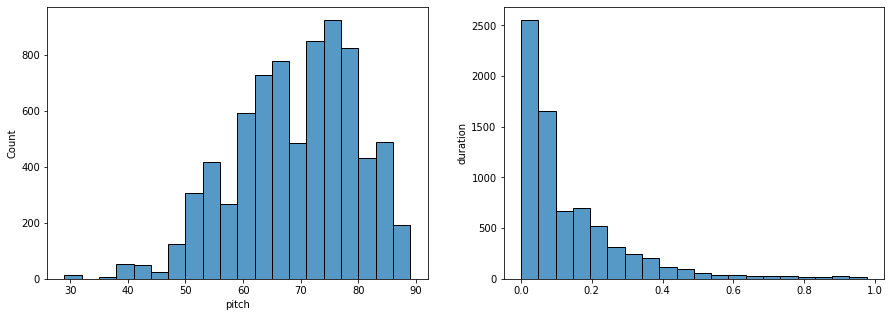

In [24]:
plot_distributions(raw_notes)

Tokenize notes. Each note is snapped to the grid of specified resolution (0.2 seconds in this example) and it's duration is set to grid step.

In [25]:
tokens = tokenize_notes(raw_notes, 0.2)
tokens.head()

,timestamp,pitch
0,5,71
1,7,72
2,7,74
3,7,67
4,7,55


Create dataset that will generate input and output token sequence

In [27]:
tokens['filename'] = 'example_filename'

dataset = NotesDataset(tokens)

For each MIDI file dataset object generates input and output tensors of size ```(last_timestamp+1, 128)```. Each row is a binary sparse vector of activated pitches, but in the output tensor rows are shifted by one to the start.

**These are going to be input and target tensors for RNN training**

In [30]:
dataset[0][0].shape, dataset[0][1].shape

(torch.Size([4153, 128]), torch.Size([4153, 128]))

In [34]:
dataset[0][0][5] == dataset[0][1][4]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

### Restore MIDI files from tokens

Convert tokens back to notes

In [35]:
restored_notes = tokens_to_notes(tokens, 0.2)
restored_notes.head()

,pitch,start,end
0,71,1.0,1.2
1,72,1.4,1.6
2,74,1.4,1.6
3,67,1.4,1.6
4,55,1.4,1.6


Plot piano roll of restored notes

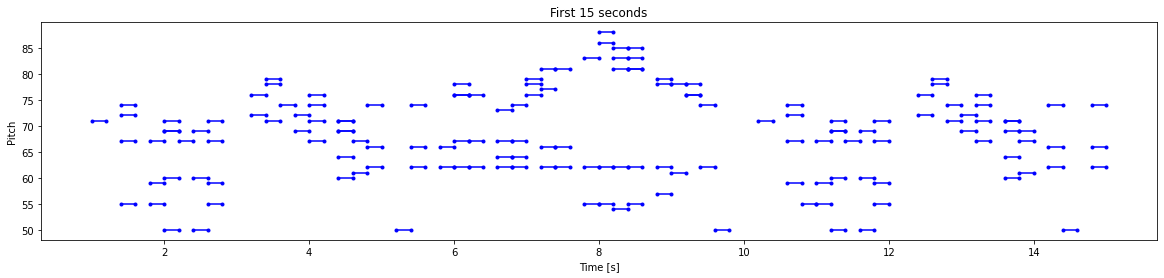

In [37]:
plot_piano_roll(restored_notes, time=15)

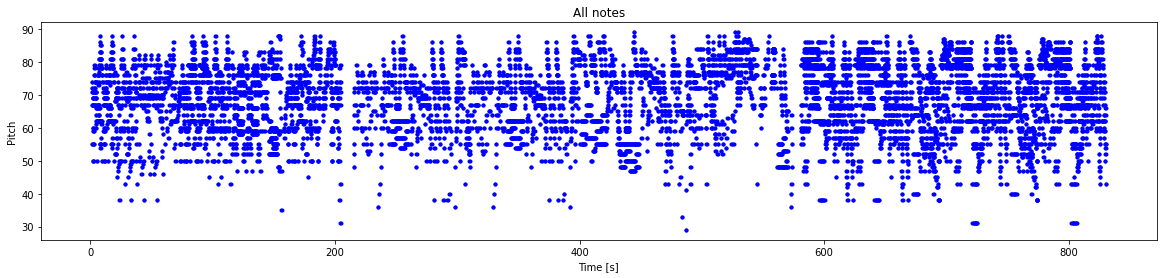

In [38]:
plot_piano_roll(restored_notes)

Display restored audio file. It's sound is not much different from the original one.

In [39]:
restored_pm = notes_to_midi(
    restored_notes,
    instrument_name=instrument_name
)

display_audio(restored_pm)